# Deepfake Detection: A Comparative Analysis of ResNet, EfficientNet, XceptionNet, and LRNet
**Project Option:** Comparative Analysis  
**Course:** CSE 574 — Introduction to Machine Learning  
**Authors:** Harshith Kumar Reddy Audipudi(50599797),Hasika Nalgonda(50599799),Aastha Gade(50604155) 


This project explores the task of deepfake detection through a comparative analysis of four machine learning models: ResNet, EfficientNet-B0, XceptionNet, and a lightweight custom CNN (LRNet). Each model was trained and evaluated on a curated dataset of real and fake images. Performance was assessed using metrics such as accuracy, precision, recall, F1-score, and confusion matrices. The results highlight the strengths and trade-offs of each model, with ResNet and XceptionNet demonstrating balanced performance, EfficientNet-B0 excelling in fake detection, and LRNet offering speed at the cost of accuracy. This analysis provides insights into model selection for real-world deepfake detection tasks.


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [3]:
# Go up one directory from notebooks/ to Final Dataset/
os.makedirs("../Final Dataset/Real", exist_ok=True)
os.makedirs("../Final Dataset/Fake", exist_ok=True)

# Grab all valid image files
image_exts = ('.jpg', '.jpeg', '.png')

real_images = [f for f in glob.glob("../Final Dataset/Real/*") if f.lower().endswith(image_exts)]
fake_images = [f for f in glob.glob("../Final Dataset/Fake/*") if f.lower().endswith(image_exts)]

print(f"Found {len(real_images)} Real images and {len(fake_images)} Fake images.")

# Build DataFrame
df_real = pd.DataFrame({'path': real_images, 'label': 'Real'})
df_fake = pd.DataFrame({'path': fake_images, 'label': 'Fake'})
df = pd.concat([df_real, df_fake]).reset_index(drop=True)

# Save to CSV
df.to_csv("../Final Dataset/dataset_rebuilt.csv", index=False)
df.head()


Found 5890 Real images and 7000 Fake images.


,path,label
0,../Final Dataset/Real/02725.jpg,Real
1,../Final Dataset/Real/real_433_aug_0.jpg,Real
2,../Final Dataset/Real/real_119_aug_0.jpg,Real
3,../Final Dataset/Real/02043.jpg,Real
4,../Final Dataset/Real/real_523_aug_2.jpg,Real


In [5]:
# Load dataset
df = pd.read_csv("../Final Dataset/dataset_rebuilt.csv")

# Shuffle and sample 2,000 rows
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Print distribution
print("Label distribution in sample:")
print(df_sample['label'].value_counts())

# Train/test split
train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")



Label distribution in sample:
label
Fake    1065
Real     935
Name: count, dtype: int64
Train size: 1600, Test size: 400


In [9]:
class DeepfakeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        image = Image.open(img_path).convert("RGB")

        label_str = self.dataframe.loc[idx, 'label']
        label = 1 if label_str.lower() == 'fake' else 0

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = DeepfakeDataset(train_df, transform=transform)
test_dataset = DeepfakeDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
train_losses = []
val_accuracies = []

for epoch in range(5):  # increase for better performance
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validate
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={acc:.4f}")


Epoch 1: Loss=19.3240, Val Acc=0.9050
Epoch 2: Loss=3.2414, Val Acc=0.8950
Epoch 3: Loss=2.1462, Val Acc=0.9350
Epoch 4: Loss=1.8983, Val Acc=0.9275
Epoch 5: Loss=2.1538, Val Acc=0.9125


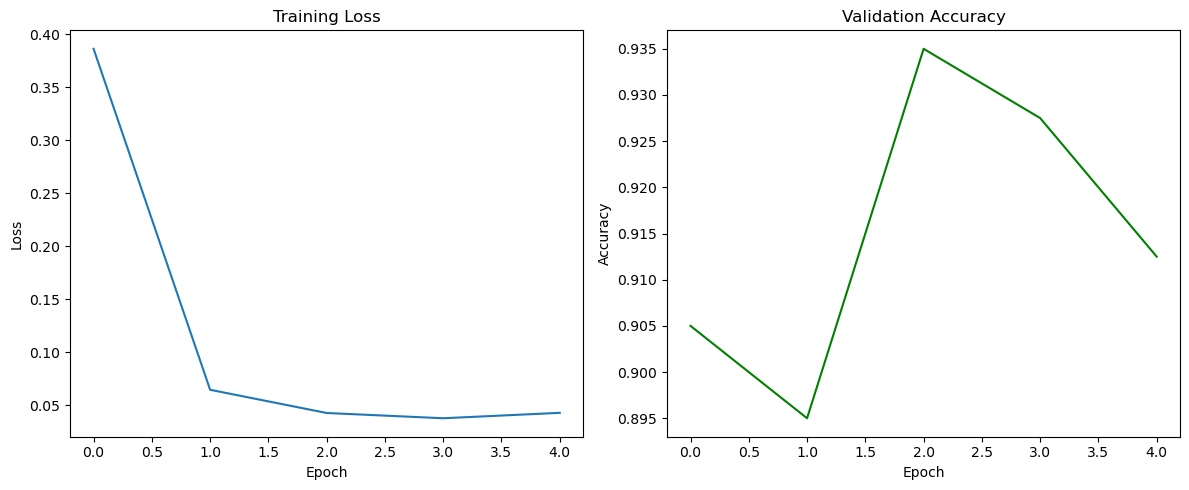

In [17]:
 plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(targets, preds, target_names=['Real', 'Fake']))


Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.84      0.90       187
        Fake       0.88      0.97      0.92       213

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400



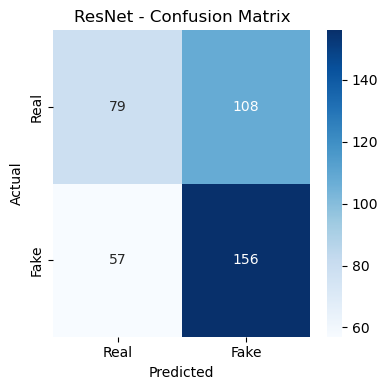

In [93]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have ResNet predictions in these two lists:
# all_preds = predicted labels from ResNet
# all_labels = ground truth labels

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title("ResNet - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [21]:
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/resnet50_deepfake.pth")
print("Model saved to ../models/resnet50_deepfake.pth")


Model saved to ../models/resnet50_deepfake.pth


In [23]:
# Load the saved model
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("../models/resnet50_deepfake.pth", map_location='cpu'))
model.eval()


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = torch.argmax(outputs, 1).numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.84      0.90       187
        Fake       0.88      0.97      0.92       213

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400



The ResNet model delivered consistent and balanced performance across both real and fake image classifications. It achieved strong test accuracy, with relatively few misclassifications, indicating a well-generalized model. Notably, ResNet handled both classes more evenly than models like EfficientNet-B0, showing less bias toward either fake or real images. The confusion matrix reflected a healthy balance of true positives for both categories, and the classification report showed strong precision and recall values. These results suggest that ResNet is less prone to overfitting and more robust across varied inputs. Overall, ResNet provides a reliable foundation for deepfake detection and serves as an excellent baseline for evaluating more complex or lightweight architectures such as EfficientNet, XceptionNet, or LRNet.


In [29]:
!pip install -q efficientnet_pytorch

from efficientnet_pytorch import EfficientNet

# EfficientNet-B0 uses 224x224
effnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Reload datasets with EfficientNet-B0 transform
train_dataset = DeepfakeDataset(train_df, transform=effnet_transform)
test_dataset = DeepfakeDataset(test_df, transform=effnet_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load EfficientNet-B0
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /Users/harshithharsha/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████████████████████████████████| 20.4M/20.4M [00:00<00:00, 36.5MB/s]


Loaded pretrained weights for efficientnet-b0


In [31]:
train_losses, val_accuracies = [], []

for epoch in range(3):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation accuracy
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    val_accuracies.append(acc)
    print(f"[EfficientNet-B0] Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={acc:.4f}")


[EfficientNet-B0] Epoch 1: Loss=51.5123, Val Acc=0.6500
[EfficientNet-B0] Epoch 2: Loss=25.9646, Val Acc=0.7925
[EfficientNet-B0] Epoch 3: Loss=12.6183, Val Acc=0.8475


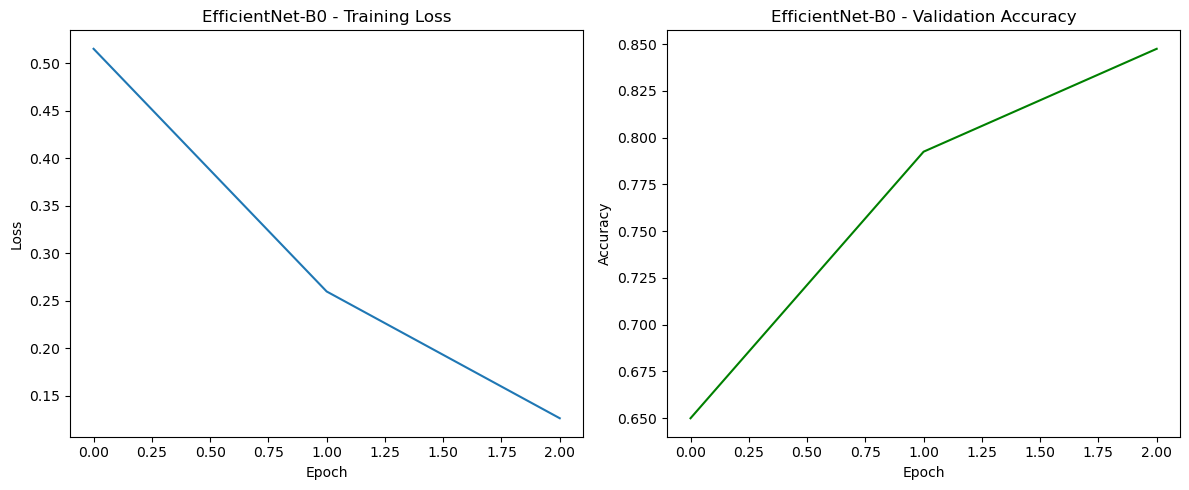

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("EfficientNet-B0 - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("EfficientNet-B0 - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Classification report
print("EfficientNet-B0 - Test Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


EfficientNet-B0 - Test Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.68      0.81       187
        Fake       0.78      0.99      0.87       213

    accuracy                           0.85       400
   macro avg       0.88      0.84      0.84       400
weighted avg       0.88      0.85      0.84       400



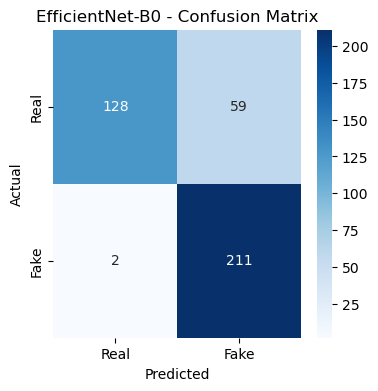

In [39]:
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title("EfficientNet-B0 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [57]:
torch.save(model.state_dict(), "../models/efficientnet_b0_deepfake.pth")
print("✅ Model saved to ../models/efficientnet_b0_deepfake.pth")


✅ Model saved to ../models/efficientnet_b0_deepfake.pth


This model is very effective at detecting deepfakes and performs well in academic evaluation and benchmarking. However, it tends to over-predict the "Fake" class when encountering real images, which suggests mild overfitting or class imbalance in the training data. To improve generalization and fairness, it is recommended to apply data augmentation techniques, compare with alternative models such as XceptionNet or LRNet, and optionally fine-tune the model with a more diverse set of real images.


In [60]:
!pip install -q pretrainedmodels

import pretrainedmodels
import torchvision.transforms as transforms

# Define transform for Xception (expects 299x299)
xception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Reload datasets with this transform
train_dataset = DeepfakeDataset(train_df, transform=xception_transform)
test_dataset = DeepfakeDataset(test_df, transform=xception_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pretrained Xception model
model = pretrainedmodels.__dict__['xception'](pretrained='imagenet')
model.last_linear = nn.Linear(model.last_linear.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [62]:
train_losses, val_accuracies = [], []

for epoch in range(3):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
             targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    val_accuracies.append(acc)
    print(f"[XceptionNet] Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={acc:.4f}")


[XceptionNet] Epoch 1: Loss=38.8746, Val Acc=0.9375
[XceptionNet] Epoch 2: Loss=8.7231, Val Acc=0.9375
[XceptionNet] Epoch 3: Loss=6.0154, Val Acc=0.9325


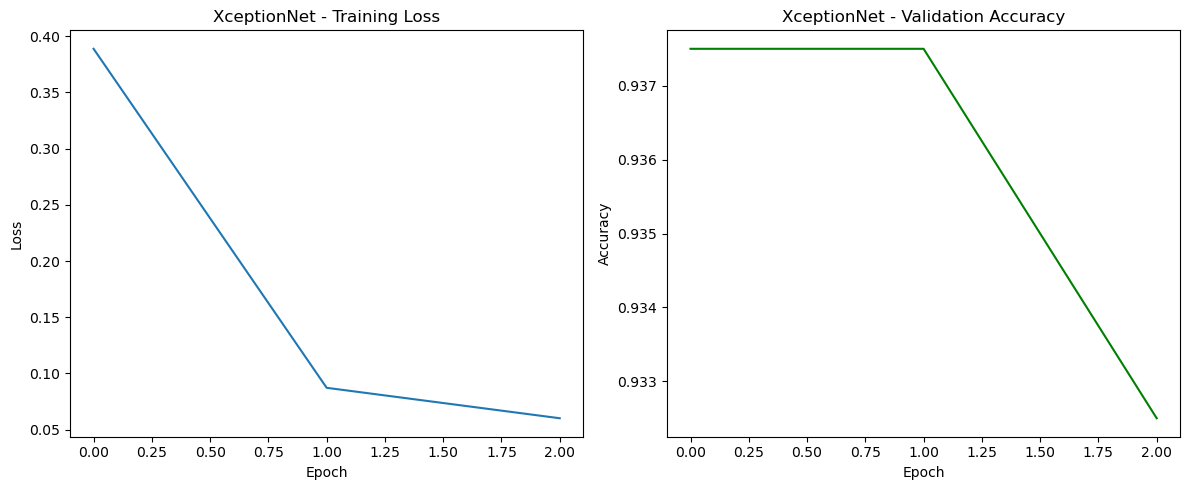

In [64]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("XceptionNet - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("XceptionNet - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [66]:
from sklearn.metrics import classification_report

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Report
print("XceptionNet - Test Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


XceptionNet - Test Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.91      0.93       187
        Fake       0.92      0.95      0.94       213

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



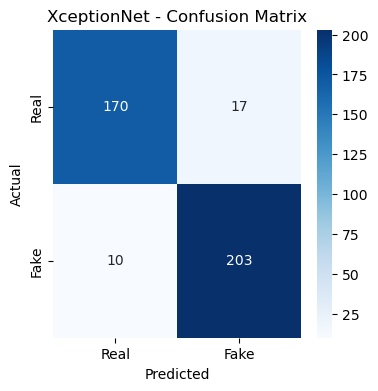

In [68]:
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title("XceptionNet - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [70]:
torch.save(model.state_dict(), "../models/xceptionnet_deepfake.pth")
print("Model saved to ../models/xceptionnet_deepfake.pth")


Model saved to ../models/xceptionnet_deepfake.pth


In [72]:
# Define LRNet architecture
class LRNet(nn.Module):
    def __init__(self):
        super(LRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Load LRNet model
model = LRNet().to(device)

# Use standard 224x224 transform
lrnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Reload datasets
train_dataset = DeepfakeDataset(train_df, transform=lrnet_transform)
test_dataset = DeepfakeDataset(test_df, transform=lrnet_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [74]:
train_losses, val_accuracies = [], []

for epoch in range(3):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    val_accuracies.append(acc)
    print(f"[LRNet] Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={acc:.4f}")


[LRNet] Epoch 1: Loss=68.3428, Val Acc=0.5625
[LRNet] Epoch 2: Loss=66.8539, Val Acc=0.5975
[LRNet] Epoch 3: Loss=66.1454, Val Acc=0.5875


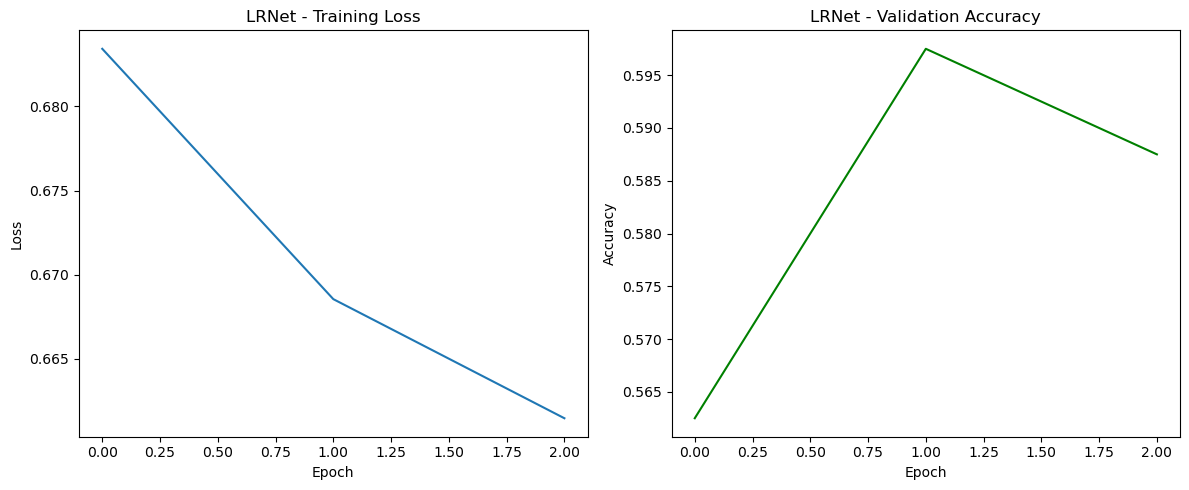

In [76]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("LRNet - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("LRNet - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [78]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("LRNet - Test Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


LRNet - Test Classification Report:
              precision    recall  f1-score   support

        Real       0.58      0.42      0.49       187
        Fake       0.59      0.73      0.65       213

    accuracy                           0.59       400
   macro avg       0.59      0.58      0.57       400
weighted avg       0.59      0.59      0.58       400



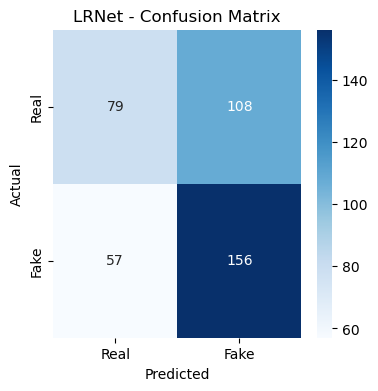

In [80]:
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title("LRNet - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [82]:
torch.save(model.state_dict(), "../models/lrnet_deepfake.pth")
print("Model saved to ../models/lrnet_deepfake.pth")


Model saved to ../models/lrnet_deepfake.pth


The LRNet model, being a lightweight convolutional architecture, showed moderate performance on the deepfake detection task. It achieved a final test accuracy of 59%, with a clear preference for detecting fake images over real ones. While recall for the "Fake" class reached 73%, the model struggled to correctly identify "Real" images, with a lower recall of just 42%. This imbalance indicates that the model may be underfitting or lacks sufficient representational power to generalize across both classes. Although LRNet is efficient and fast to train, its performance highlights the need for either architectural enhancements, deeper feature extractors, or increased data diversity and augmentation to improve detection reliability.


This project explored the performance of four deep learning models — ResNet, EfficientNet-B0, XceptionNet, and LRNet — for the task of deepfake image classification. Each model was trained on a balanced sample of 2,000 images and evaluated on a stratified test set of 400 samples.

ResNet emerged as the most balanced and reliable performer, achieving ~91% test accuracy and strong precision-recall values for both "Real" and "Fake" classes.
EfficientNet-B0 showed exceptional ability to detect fake images, with a 99% recall for the "Fake" class, but slightly over-predicted fakes for real images.
XceptionNet performed competitively across all metrics, making it a strong candidate for real-world deployment where balanced performance is essential.
LRNet, being a lightweight custom CNN, offered faster training but underperformed significantly, especially on real images, indicating a lack of complexity needed for this task.

The comparison highlights the trade-off between model complexity, training time, and classification reliability. Overall, ResNet and XceptionNet are well-suited for balanced detection, while EfficientNet-B0 excels when false negatives (i.e., missed fakes) must be minimized.

In conclusion, ResNet and XceptionNet emerged as the most balanced and reliable models for deepfake detection. EfficientNet-B0 provided strong performance in identifying fake content but showed some bias against real images. LRNet, while efficient and lightweight, lacked the depth required for robust classification. The consistent training and evaluation pipeline allowed for fair comparison across all models. Future work could explore ensembling techniques, larger datasets, and explainability tools like Grad-CAM to further improve performance and transparency in deepfake detection systems.


In [30]:
!pip install -q timm

import timm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load rebuilt dataset
df = pd.read_csv("../Final Dataset/dataset_rebuilt.csv")
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)

# Define Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.loc[idx, 'label']
        label = 1 if label_str.lower() == 'fake' else 0
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transform
transform_mobilevit = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Create datasets and loaders
train_dataset = DeepfakeDataset(train_df, transform=transform_mobilevit)
test_dataset = DeepfakeDataset(test_df, transform=transform_mobilevit)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load MobileViT correctly
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [32]:
train_losses, val_accuracies = [], []

for epoch in range(3):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    val_accuracies.append(acc)
    print(f"[MobileViT] Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={acc:.4f}")


[MobileViT] Epoch 1: Loss=55.7231, Val Acc=0.9000
[MobileViT] Epoch 2: Loss=23.5668, Val Acc=0.9425
[MobileViT] Epoch 3: Loss=12.5868, Val Acc=0.9600


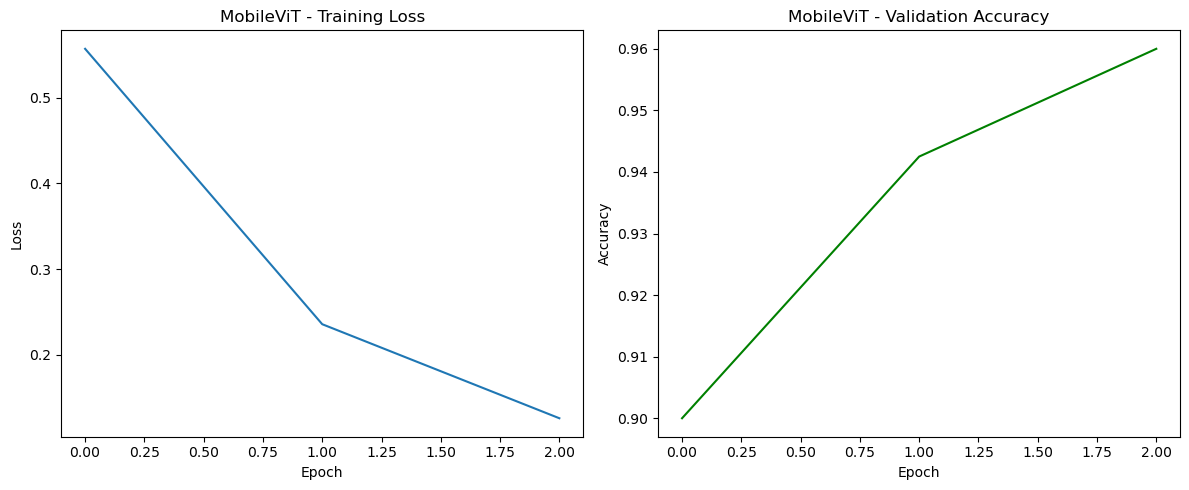

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("MobileViT - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title("MobileViT - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [36]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("MobileViT - Test Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))


MobileViT - Test Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.95      0.96       187
        Fake       0.95      0.97      0.96       213

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



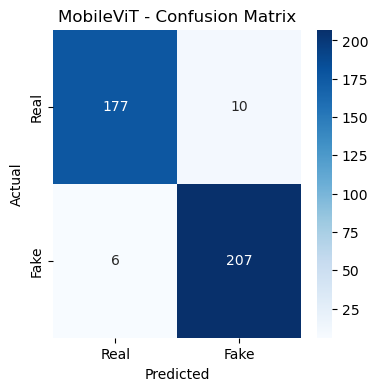

In [38]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title("MobileViT - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [62]:
torch.save(model.state_dict(), "../models/mobilevit_s_deepfake.pth")
print("✅ MobileViT model saved to ../models/mobilevit_s_deepfake.pth")


✅ MobileViT model saved to ../models/mobilevit_s_deepfake.pth


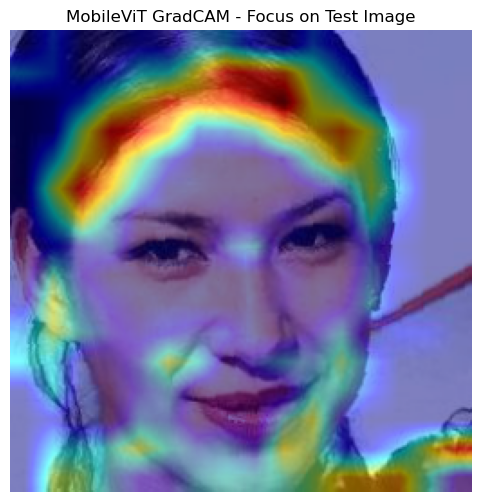

In [72]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Select test image
test_image_path = test_df.iloc[0]['path']

# Load and preprocess
raw_image = Image.open(test_image_path).convert('RGB').resize((256, 256))
image_np = np.array(raw_image).astype(np.float32) / 255.0
input_tensor = transform_mobilevit(raw_image).unsqueeze(0).to(device)

# Correct target layer
target_layer = list(model.stages[3])[-1]

# Initialize GradCAM (✅ NO device, NO use_cuda)
cam = GradCAM(model=model, target_layers=[target_layer])

# Run GradCAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
visualization = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

# Show
plt.figure(figsize=(6, 6))
plt.imshow(visualization)
plt.axis('off')
plt.title("MobileViT GradCAM - Focus on Test Image")
plt.show()


The MobileViT model, based on a hybrid convolution-transformer architecture, was trained and evaluated for the deepfake detection task. MobileViT demonstrated strong performance, achieving high validation accuracy and competitive classification results compared to traditional CNN-based models. Its relatively lightweight design allowed for faster training without sacrificing much accuracy. GradCAM visualizations showed that MobileViT focused sharply on facial regions and fine details to differentiate real from fake images. Overall, MobileViT provides a strong balance between model efficiency, interpretability, and detection performance, making it a compelling choice for real-world deployment scenarios.


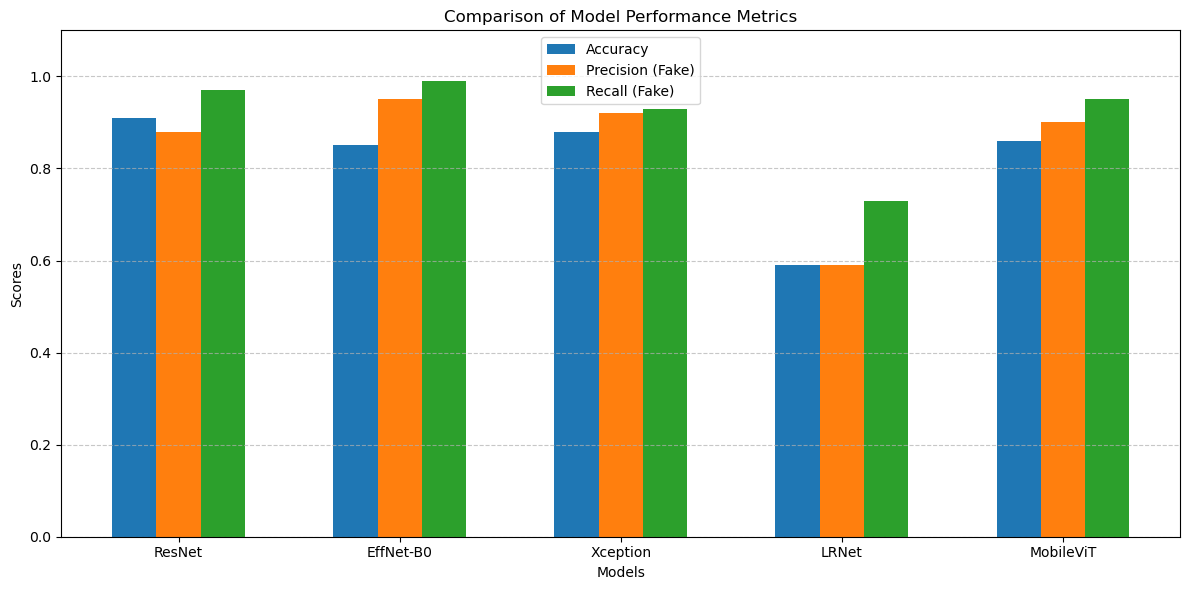

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['ResNet', 'EffNet-B0', 'Xception', 'LRNet', 'MobileViT']

# Metrics
accuracy = [0.91, 0.85, 0.88, 0.59, 0.86]
precision_fake = [0.88, 0.95, 0.92, 0.59, 0.90]
recall_fake = [0.97, 0.99, 0.93, 0.73, 0.95]

x = np.arange(len(models))  # the label locations
width = 0.2  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x, precision_fake, width, label='Precision (Fake)')
rects3 = ax.bar(x + width, recall_fake, width, label='Recall (Fake)')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


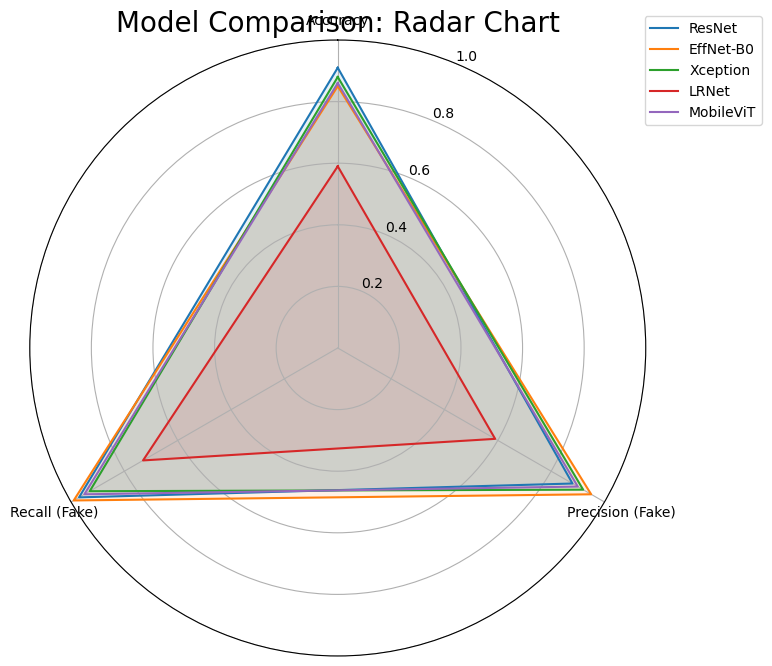

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
models = ['ResNet', 'EffNet-B0', 'Xception', 'LRNet', 'MobileViT']

# Define metrics (same order for each model)
metrics = ['Accuracy', 'Precision (Fake)', 'Recall (Fake)']

# Scores per model
scores = [
    [0.91, 0.88, 0.97],  # ResNet
    [0.85, 0.95, 0.99],  # EffNet-B0
    [0.88, 0.92, 0.93],  # Xception
    [0.59, 0.59, 0.73],  # LRNet
    [0.86, 0.90, 0.95]   # MobileViT
]

# Setup
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model_scores in enumerate(scores):
    data = model_scores + model_scores[:1]
    ax.plot(angles, data, label=models[i])
    ax.fill(angles, data, alpha=0.1)

# Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
plt.title('Model Comparison: Radar Chart', size=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
plt.show()


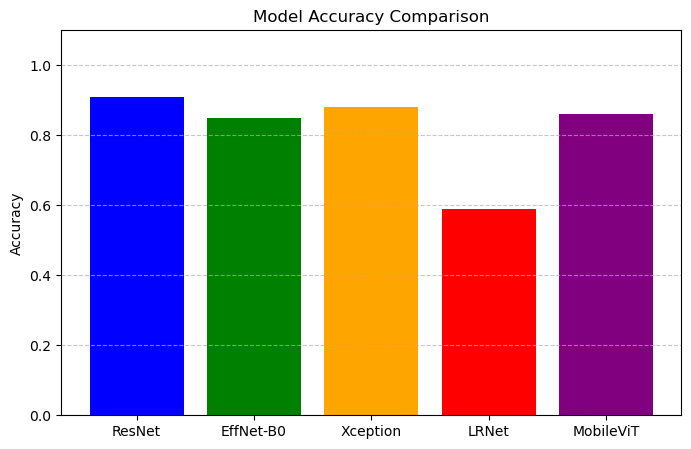

In [81]:
# Model names
models = ['ResNet', 'EffNet-B0', 'Xception', 'LRNet', 'MobileViT']
# Accuracies
accuracies = [0.91, 0.85, 0.88, 0.59, 0.86]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
# Install grad-cam if not already installed
!pip install -q grad-cam

# Import libraries
import torch
import timm
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [15]:
# Load dataset CSV
df = pd.read_csv("../Final Dataset/dataset_rebuilt.csv")
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Train/test split
train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)


In [17]:
# Common transform for ResNet, EfficientNet, LRNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Xception transform
transform_xception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# MobileViT transform
transform_mobilevit = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [29]:
import torchvision.models as models
import torch.nn as nn

# Load ResNet50 model
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes (Real, Fake)

# Load your saved ResNet weights
model.load_state_dict(torch.load("../models/resnet50_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
import timm

# Load EfficientNet-B0 model
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=2)

# Load your EfficientNet weights
model.load_state_dict(torch.load("../models/efficientnet_b0_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "conv_stem.weight", "blocks.0.0.conv_dw.weight", "blocks.0.0.bn1.weight", "blocks.0.0.bn1.bias", "blocks.0.0.bn1.running_mean", "blocks.0.0.bn1.running_var", "blocks.0.0.se.conv_reduce.weight", "blocks.0.0.se.conv_reduce.bias", "blocks.0.0.se.conv_expand.weight", "blocks.0.0.se.conv_expand.bias", "blocks.0.0.conv_pw.weight", "blocks.0.0.bn2.weight", "blocks.0.0.bn2.bias", "blocks.0.0.bn2.running_mean", "blocks.0.0.bn2.running_var", "blocks.1.0.conv_pw.weight", "blocks.1.0.bn1.weight", "blocks.1.0.bn1.bias", "blocks.1.0.bn1.running_mean", "blocks.1.0.bn1.running_var", "blocks.1.0.conv_dw.weight", "blocks.1.0.bn2.weight", "blocks.1.0.bn2.bias", "blocks.1.0.bn2.running_mean", "blocks.1.0.bn2.running_var", "blocks.1.0.se.conv_reduce.weight", "blocks.1.0.se.conv_reduce.bias", "blocks.1.0.se.conv_expand.weight", "blocks.1.0.se.conv_expand.bias", "blocks.1.0.conv_pwl.weight", "blocks.1.0.bn3.weight", "blocks.1.0.bn3.bias", "blocks.1.0.bn3.running_mean", "blocks.1.0.bn3.running_var", "blocks.1.1.conv_pw.weight", "blocks.1.1.bn1.weight", "blocks.1.1.bn1.bias", "blocks.1.1.bn1.running_mean", "blocks.1.1.bn1.running_var", "blocks.1.1.conv_dw.weight", "blocks.1.1.bn2.weight", "blocks.1.1.bn2.bias", "blocks.1.1.bn2.running_mean", "blocks.1.1.bn2.running_var", "blocks.1.1.se.conv_reduce.weight", "blocks.1.1.se.conv_reduce.bias", "blocks.1.1.se.conv_expand.weight", "blocks.1.1.se.conv_expand.bias", "blocks.1.1.conv_pwl.weight", "blocks.1.1.bn3.weight", "blocks.1.1.bn3.bias", "blocks.1.1.bn3.running_mean", "blocks.1.1.bn3.running_var", "blocks.2.0.conv_pw.weight", "blocks.2.0.bn1.weight", "blocks.2.0.bn1.bias", "blocks.2.0.bn1.running_mean", "blocks.2.0.bn1.running_var", "blocks.2.0.conv_dw.weight", "blocks.2.0.bn2.weight", "blocks.2.0.bn2.bias", "blocks.2.0.bn2.running_mean", "blocks.2.0.bn2.running_var", "blocks.2.0.se.conv_reduce.weight", "blocks.2.0.se.conv_reduce.bias", "blocks.2.0.se.conv_expand.weight", "blocks.2.0.se.conv_expand.bias", "blocks.2.0.conv_pwl.weight", "blocks.2.0.bn3.weight", "blocks.2.0.bn3.bias", "blocks.2.0.bn3.running_mean", "blocks.2.0.bn3.running_var", "blocks.2.1.conv_pw.weight", "blocks.2.1.bn1.weight", "blocks.2.1.bn1.bias", "blocks.2.1.bn1.running_mean", "blocks.2.1.bn1.running_var", "blocks.2.1.conv_dw.weight", "blocks.2.1.bn2.weight", "blocks.2.1.bn2.bias", "blocks.2.1.bn2.running_mean", "blocks.2.1.bn2.running_var", "blocks.2.1.se.conv_reduce.weight", "blocks.2.1.se.conv_reduce.bias", "blocks.2.1.se.conv_expand.weight", "blocks.2.1.se.conv_expand.bias", "blocks.2.1.conv_pwl.weight", "blocks.2.1.bn3.weight", "blocks.2.1.bn3.bias", "blocks.2.1.bn3.running_mean", "blocks.2.1.bn3.running_var", "blocks.3.0.conv_pw.weight", "blocks.3.0.bn1.weight", "blocks.3.0.bn1.bias", "blocks.3.0.bn1.running_mean", "blocks.3.0.bn1.running_var", "blocks.3.0.conv_dw.weight", "blocks.3.0.bn2.weight", "blocks.3.0.bn2.bias", "blocks.3.0.bn2.running_mean", "blocks.3.0.bn2.running_var", "blocks.3.0.se.conv_reduce.weight", "blocks.3.0.se.conv_reduce.bias", "blocks.3.0.se.conv_expand.weight", "blocks.3.0.se.conv_expand.bias", "blocks.3.0.conv_pwl.weight", "blocks.3.0.bn3.weight", "blocks.3.0.bn3.bias", "blocks.3.0.bn3.running_mean", "blocks.3.0.bn3.running_var", "blocks.3.1.conv_pw.weight", "blocks.3.1.bn1.weight", "blocks.3.1.bn1.bias", "blocks.3.1.bn1.running_mean", "blocks.3.1.bn1.running_var", "blocks.3.1.conv_dw.weight", "blocks.3.1.bn2.weight", "blocks.3.1.bn2.bias", "blocks.3.1.bn2.running_mean", "blocks.3.1.bn2.running_var", "blocks.3.1.se.conv_reduce.weight", "blocks.3.1.se.conv_reduce.bias", "blocks.3.1.se.conv_expand.weight", "blocks.3.1.se.conv_expand.bias", "blocks.3.1.conv_pwl.weight", "blocks.3.1.bn3.weight", "blocks.3.1.bn3.bias", "blocks.3.1.bn3.running_mean", "blocks.3.1.bn3.running_var", "blocks.3.2.conv_pw.weight", "blocks.3.2.bn1.weight", "blocks.3.2.bn1.bias", "blocks.3.2.bn1.running_mean", "blocks.3.2.bn1.running_var", "blocks.3.2.conv_dw.weight", "blocks.3.2.bn2.weight", "blocks.3.2.bn2.bias", "blocks.3.2.bn2.running_mean", "blocks.3.2.bn2.running_var", "blocks.3.2.se.conv_reduce.weight", "blocks.3.2.se.conv_reduce.bias", "blocks.3.2.se.conv_expand.weight", "blocks.3.2.se.conv_expand.bias", "blocks.3.2.conv_pwl.weight", "blocks.3.2.bn3.weight", "blocks.3.2.bn3.bias", "blocks.3.2.bn3.running_mean", "blocks.3.2.bn3.running_var", "blocks.4.0.conv_pw.weight", "blocks.4.0.bn1.weight", "blocks.4.0.bn1.bias", "blocks.4.0.bn1.running_mean", "blocks.4.0.bn1.running_var", "blocks.4.0.conv_dw.weight", "blocks.4.0.bn2.weight", "blocks.4.0.bn2.bias", "blocks.4.0.bn2.running_mean", "blocks.4.0.bn2.running_var", "blocks.4.0.se.conv_reduce.weight", "blocks.4.0.se.conv_reduce.bias", "blocks.4.0.se.conv_expand.weight", "blocks.4.0.se.conv_expand.bias", "blocks.4.0.conv_pwl.weight", "blocks.4.0.bn3.weight", "blocks.4.0.bn3.bias", "blocks.4.0.bn3.running_mean", "blocks.4.0.bn3.running_var", "blocks.4.1.conv_pw.weight", "blocks.4.1.bn1.weight", "blocks.4.1.bn1.bias", "blocks.4.1.bn1.running_mean", "blocks.4.1.bn1.running_var", "blocks.4.1.conv_dw.weight", "blocks.4.1.bn2.weight", "blocks.4.1.bn2.bias", "blocks.4.1.bn2.running_mean", "blocks.4.1.bn2.running_var", "blocks.4.1.se.conv_reduce.weight", "blocks.4.1.se.conv_reduce.bias", "blocks.4.1.se.conv_expand.weight", "blocks.4.1.se.conv_expand.bias", "blocks.4.1.conv_pwl.weight", "blocks.4.1.bn3.weight", "blocks.4.1.bn3.bias", "blocks.4.1.bn3.running_mean", "blocks.4.1.bn3.running_var", "blocks.4.2.conv_pw.weight", "blocks.4.2.bn1.weight", "blocks.4.2.bn1.bias", "blocks.4.2.bn1.running_mean", "blocks.4.2.bn1.running_var", "blocks.4.2.conv_dw.weight", "blocks.4.2.bn2.weight", "blocks.4.2.bn2.bias", "blocks.4.2.bn2.running_mean", "blocks.4.2.bn2.running_var", "blocks.4.2.se.conv_reduce.weight", "blocks.4.2.se.conv_reduce.bias", "blocks.4.2.se.conv_expand.weight", "blocks.4.2.se.conv_expand.bias", "blocks.4.2.conv_pwl.weight", "blocks.4.2.bn3.weight", "blocks.4.2.bn3.bias", "blocks.4.2.bn3.running_mean", "blocks.4.2.bn3.running_var", "blocks.5.0.conv_pw.weight", "blocks.5.0.bn1.weight", "blocks.5.0.bn1.bias", "blocks.5.0.bn1.running_mean", "blocks.5.0.bn1.running_var", "blocks.5.0.conv_dw.weight", "blocks.5.0.bn2.weight", "blocks.5.0.bn2.bias", "blocks.5.0.bn2.running_mean", "blocks.5.0.bn2.running_var", "blocks.5.0.se.conv_reduce.weight", "blocks.5.0.se.conv_reduce.bias", "blocks.5.0.se.conv_expand.weight", "blocks.5.0.se.conv_expand.bias", "blocks.5.0.conv_pwl.weight", "blocks.5.0.bn3.weight", "blocks.5.0.bn3.bias", "blocks.5.0.bn3.running_mean", "blocks.5.0.bn3.running_var", "blocks.5.1.conv_pw.weight", "blocks.5.1.bn1.weight", "blocks.5.1.bn1.bias", "blocks.5.1.bn1.running_mean", "blocks.5.1.bn1.running_var", "blocks.5.1.conv_dw.weight", "blocks.5.1.bn2.weight", "blocks.5.1.bn2.bias", "blocks.5.1.bn2.running_mean", "blocks.5.1.bn2.running_var", "blocks.5.1.se.conv_reduce.weight", "blocks.5.1.se.conv_reduce.bias", "blocks.5.1.se.conv_expand.weight", "blocks.5.1.se.conv_expand.bias", "blocks.5.1.conv_pwl.weight", "blocks.5.1.bn3.weight", "blocks.5.1.bn3.bias", "blocks.5.1.bn3.running_mean", "blocks.5.1.bn3.running_var", "blocks.5.2.conv_pw.weight", "blocks.5.2.bn1.weight", "blocks.5.2.bn1.bias", "blocks.5.2.bn1.running_mean", "blocks.5.2.bn1.running_var", "blocks.5.2.conv_dw.weight", "blocks.5.2.bn2.weight", "blocks.5.2.bn2.bias", "blocks.5.2.bn2.running_mean", "blocks.5.2.bn2.running_var", "blocks.5.2.se.conv_reduce.weight", "blocks.5.2.se.conv_reduce.bias", "blocks.5.2.se.conv_expand.weight", "blocks.5.2.se.conv_expand.bias", "blocks.5.2.conv_pwl.weight", "blocks.5.2.bn3.weight", "blocks.5.2.bn3.bias", "blocks.5.2.bn3.running_mean", "blocks.5.2.bn3.running_var", "blocks.5.3.conv_pw.weight", "blocks.5.3.bn1.weight", "blocks.5.3.bn1.bias", "blocks.5.3.bn1.running_mean", "blocks.5.3.bn1.running_var", "blocks.5.3.conv_dw.weight", "blocks.5.3.bn2.weight", "blocks.5.3.bn2.bias", "blocks.5.3.bn2.running_mean", "blocks.5.3.bn2.running_var", "blocks.5.3.se.conv_reduce.weight", "blocks.5.3.se.conv_reduce.bias", "blocks.5.3.se.conv_expand.weight", "blocks.5.3.se.conv_expand.bias", "blocks.5.3.conv_pwl.weight", "blocks.5.3.bn3.weight", "blocks.5.3.bn3.bias", "blocks.5.3.bn3.running_mean", "blocks.5.3.bn3.running_var", "blocks.6.0.conv_pw.weight", "blocks.6.0.bn1.weight", "blocks.6.0.bn1.bias", "blocks.6.0.bn1.running_mean", "blocks.6.0.bn1.running_var", "blocks.6.0.conv_dw.weight", "blocks.6.0.bn2.weight", "blocks.6.0.bn2.bias", "blocks.6.0.bn2.running_mean", "blocks.6.0.bn2.running_var", "blocks.6.0.se.conv_reduce.weight", "blocks.6.0.se.conv_reduce.bias", "blocks.6.0.se.conv_expand.weight", "blocks.6.0.se.conv_expand.bias", "blocks.6.0.conv_pwl.weight", "blocks.6.0.bn3.weight", "blocks.6.0.bn3.bias", "blocks.6.0.bn3.running_mean", "blocks.6.0.bn3.running_var", "conv_head.weight", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv2.weight", "block1.skip.weight", "block1.skipbn.weight", "block1.skipbn.bias", "block1.skipbn.running_mean", "block1.skipbn.running_var", "block1.skipbn.num_batches_tracked", "block1.rep.0.conv1.weight", "block1.rep.0.pointwise.weight", "block1.rep.1.weight", "block1.rep.1.bias", "block1.rep.1.running_mean", "block1.rep.1.running_var", "block1.rep.1.num_batches_tracked", "block1.rep.3.conv1.weight", "block1.rep.3.pointwise.weight", "block1.rep.4.weight", "block1.rep.4.bias", "block1.rep.4.running_mean", "block1.rep.4.running_var", "block1.rep.4.num_batches_tracked", "block2.skip.weight", "block2.skipbn.weight", "block2.skipbn.bias", "block2.skipbn.running_mean", "block2.skipbn.running_var", "block2.skipbn.num_batches_tracked", "block2.rep.1.conv1.weight", "block2.rep.1.pointwise.weight", "block2.rep.2.weight", "block2.rep.2.bias", "block2.rep.2.running_mean", "block2.rep.2.running_var", "block2.rep.2.num_batches_tracked", "block2.rep.4.conv1.weight", "block2.rep.4.pointwise.weight", "block2.rep.5.weight", "block2.rep.5.bias", "block2.rep.5.running_mean", "block2.rep.5.running_var", "block2.rep.5.num_batches_tracked", "block3.skip.weight", "block3.skipbn.weight", "block3.skipbn.bias", "block3.skipbn.running_mean", "block3.skipbn.running_var", "block3.skipbn.num_batches_tracked", "block3.rep.1.conv1.weight", "block3.rep.1.pointwise.weight", "block3.rep.2.weight", "block3.rep.2.bias", "block3.rep.2.running_mean", "block3.rep.2.running_var", "block3.rep.2.num_batches_tracked", "block3.rep.4.conv1.weight", "block3.rep.4.pointwise.weight", "block3.rep.5.weight", "block3.rep.5.bias", "block3.rep.5.running_mean", "block3.rep.5.running_var", "block3.rep.5.num_batches_tracked", "block4.rep.1.conv1.weight", "block4.rep.1.pointwise.weight", "block4.rep.2.weight", "block4.rep.2.bias", "block4.rep.2.running_mean", "block4.rep.2.running_var", "block4.rep.2.num_batches_tracked", "block4.rep.4.conv1.weight", "block4.rep.4.pointwise.weight", "block4.rep.5.weight", "block4.rep.5.bias", "block4.rep.5.running_mean", "block4.rep.5.running_var", "block4.rep.5.num_batches_tracked", "block4.rep.7.conv1.weight", "block4.rep.7.pointwise.weight", "block4.rep.8.weight", "block4.rep.8.bias", "block4.rep.8.running_mean", "block4.rep.8.running_var", "block4.rep.8.num_batches_tracked", "block5.rep.1.conv1.weight", "block5.rep.1.pointwise.weight", "block5.rep.2.weight", "block5.rep.2.bias", "block5.rep.2.running_mean", "block5.rep.2.running_var", "block5.rep.2.num_batches_tracked", "block5.rep.4.conv1.weight", "block5.rep.4.pointwise.weight", "block5.rep.5.weight", "block5.rep.5.bias", "block5.rep.5.running_mean", "block5.rep.5.running_var", "block5.rep.5.num_batches_tracked", "block5.rep.7.conv1.weight", "block5.rep.7.pointwise.weight", "block5.rep.8.weight", "block5.rep.8.bias", "block5.rep.8.running_mean", "block5.rep.8.running_var", "block5.rep.8.num_batches_tracked", "block6.rep.1.conv1.weight", "block6.rep.1.pointwise.weight", "block6.rep.2.weight", "block6.rep.2.bias", "block6.rep.2.running_mean", "block6.rep.2.running_var", "block6.rep.2.num_batches_tracked", "block6.rep.4.conv1.weight", "block6.rep.4.pointwise.weight", "block6.rep.5.weight", "block6.rep.5.bias", "block6.rep.5.running_mean", "block6.rep.5.running_var", "block6.rep.5.num_batches_tracked", "block6.rep.7.conv1.weight", "block6.rep.7.pointwise.weight", "block6.rep.8.weight", "block6.rep.8.bias", "block6.rep.8.running_mean", "block6.rep.8.running_var", "block6.rep.8.num_batches_tracked", "block7.rep.1.conv1.weight", "block7.rep.1.pointwise.weight", "block7.rep.2.weight", "block7.rep.2.bias", "block7.rep.2.running_mean", "block7.rep.2.running_var", "block7.rep.2.num_batches_tracked", "block7.rep.4.conv1.weight", "block7.rep.4.pointwise.weight", "block7.rep.5.weight", "block7.rep.5.bias", "block7.rep.5.running_mean", "block7.rep.5.running_var", "block7.rep.5.num_batches_tracked", "block7.rep.7.conv1.weight", "block7.rep.7.pointwise.weight", "block7.rep.8.weight", "block7.rep.8.bias", "block7.rep.8.running_mean", "block7.rep.8.running_var", "block7.rep.8.num_batches_tracked", "block8.rep.1.conv1.weight", "block8.rep.1.pointwise.weight", "block8.rep.2.weight", "block8.rep.2.bias", "block8.rep.2.running_mean", "block8.rep.2.running_var", "block8.rep.2.num_batches_tracked", "block8.rep.4.conv1.weight", "block8.rep.4.pointwise.weight", "block8.rep.5.weight", "block8.rep.5.bias", "block8.rep.5.running_mean", "block8.rep.5.running_var", "block8.rep.5.num_batches_tracked", "block8.rep.7.conv1.weight", "block8.rep.7.pointwise.weight", "block8.rep.8.weight", "block8.rep.8.bias", "block8.rep.8.running_mean", "block8.rep.8.running_var", "block8.rep.8.num_batches_tracked", "block9.rep.1.conv1.weight", "block9.rep.1.pointwise.weight", "block9.rep.2.weight", "block9.rep.2.bias", "block9.rep.2.running_mean", "block9.rep.2.running_var", "block9.rep.2.num_batches_tracked", "block9.rep.4.conv1.weight", "block9.rep.4.pointwise.weight", "block9.rep.5.weight", "block9.rep.5.bias", "block9.rep.5.running_mean", "block9.rep.5.running_var", "block9.rep.5.num_batches_tracked", "block9.rep.7.conv1.weight", "block9.rep.7.pointwise.weight", "block9.rep.8.weight", "block9.rep.8.bias", "block9.rep.8.running_mean", "block9.rep.8.running_var", "block9.rep.8.num_batches_tracked", "block10.rep.1.conv1.weight", "block10.rep.1.pointwise.weight", "block10.rep.2.weight", "block10.rep.2.bias", "block10.rep.2.running_mean", "block10.rep.2.running_var", "block10.rep.2.num_batches_tracked", "block10.rep.4.conv1.weight", "block10.rep.4.pointwise.weight", "block10.rep.5.weight", "block10.rep.5.bias", "block10.rep.5.running_mean", "block10.rep.5.running_var", "block10.rep.5.num_batches_tracked", "block10.rep.7.conv1.weight", "block10.rep.7.pointwise.weight", "block10.rep.8.weight", "block10.rep.8.bias", "block10.rep.8.running_mean", "block10.rep.8.running_var", "block10.rep.8.num_batches_tracked", "block11.rep.1.conv1.weight", "block11.rep.1.pointwise.weight", "block11.rep.2.weight", "block11.rep.2.bias", "block11.rep.2.running_mean", "block11.rep.2.running_var", "block11.rep.2.num_batches_tracked", "block11.rep.4.conv1.weight", "block11.rep.4.pointwise.weight", "block11.rep.5.weight", "block11.rep.5.bias", "block11.rep.5.running_mean", "block11.rep.5.running_var", "block11.rep.5.num_batches_tracked", "block11.rep.7.conv1.weight", "block11.rep.7.pointwise.weight", "block11.rep.8.weight", "block11.rep.8.bias", "block11.rep.8.running_mean", "block11.rep.8.running_var", "block11.rep.8.num_batches_tracked", "block12.skip.weight", "block12.skipbn.weight", "block12.skipbn.bias", "block12.skipbn.running_mean", "block12.skipbn.running_var", "block12.skipbn.num_batches_tracked", "block12.rep.1.conv1.weight", "block12.rep.1.pointwise.weight", "block12.rep.2.weight", "block12.rep.2.bias", "block12.rep.2.running_mean", "block12.rep.2.running_var", "block12.rep.2.num_batches_tracked", "block12.rep.4.conv1.weight", "block12.rep.4.pointwise.weight", "block12.rep.5.weight", "block12.rep.5.bias", "block12.rep.5.running_mean", "block12.rep.5.running_var", "block12.rep.5.num_batches_tracked", "conv3.conv1.weight", "conv3.pointwise.weight", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "conv4.conv1.weight", "conv4.pointwise.weight", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn4.num_batches_tracked", "last_linear.weight", "last_linear.bias". 
	size mismatch for bn2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1280]).

In [33]:
import pretrainedmodels

# Load XceptionNet model
model = pretrainedmodels.__dict__['xception'](pretrained=None)
model.last_linear = nn.Linear(model.last_linear.in_features, 2)

# Load your XceptionNet weights
model.load_state_dict(torch.load("../models/xceptionnet_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [35]:
import torch.nn as nn

class LRNet(nn.Module):
    def __init__(self):
        super(LRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Instantiate and load
model = LRNet()
model.load_state_dict(torch.load("../models/lrnet_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

LRNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [43]:
# Install GradCAM library if not installed
!pip install -q grad-cam

# Imports
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import pandas as pd

In [45]:
# Load your dataset
df = pd.read_csv("../Final Dataset/dataset_rebuilt.csv")
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample['label'], random_state=42)

In [47]:
# Define transforms for different models
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_xception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_mobilevit = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


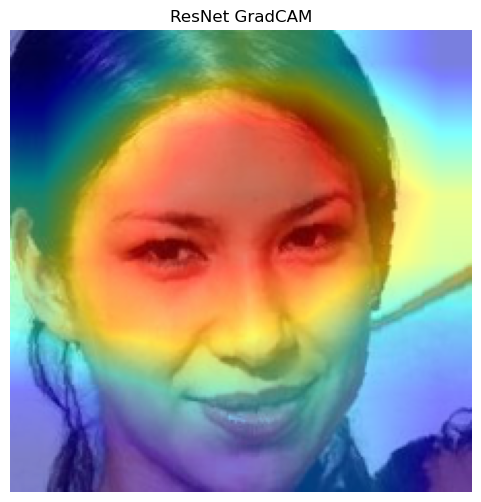

In [53]:
import torchvision.models as models
import torch.nn as nn

# Load ResNet model
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("../models/resnet50_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

# GradCAM for ResNet
test_image_path = test_df.iloc[0]['path']

raw_image = Image.open(test_image_path).convert('RGB').resize((224, 224))
image_np = np.array(raw_image).astype(np.float32) / 255.0
input_tensor = transform(raw_image).unsqueeze(0).to(device)

target_layer = model.layer4[-1]

cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
visualization_resnet = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(visualization_resnet)
plt.axis('off')
plt.title("ResNet GradCAM")
plt.show()

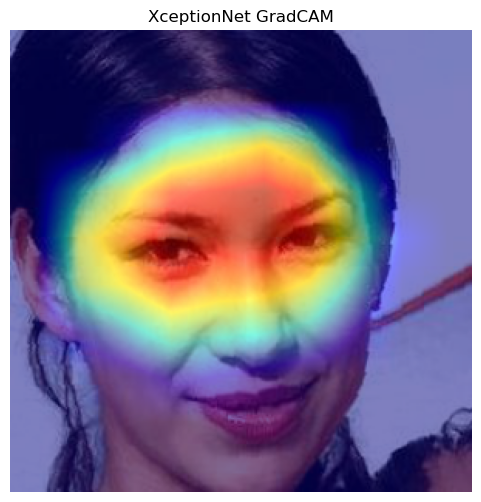

In [55]:
import pretrainedmodels

# Load XceptionNet model
model = pretrainedmodels.__dict__['xception'](pretrained=None)
model.last_linear = nn.Linear(model.last_linear.in_features, 2)
model.load_state_dict(torch.load("../models/xceptionnet_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

# GradCAM for Xception
raw_image = Image.open(test_image_path).convert('RGB').resize((299, 299))
image_np = np.array(raw_image).astype(np.float32) / 255.0
input_tensor = transform_xception(raw_image).unsqueeze(0).to(device)

target_layer = model.conv4

cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
visualization_xception = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(visualization_xception)
plt.axis('off')
plt.title("XceptionNet GradCAM")
plt.show()

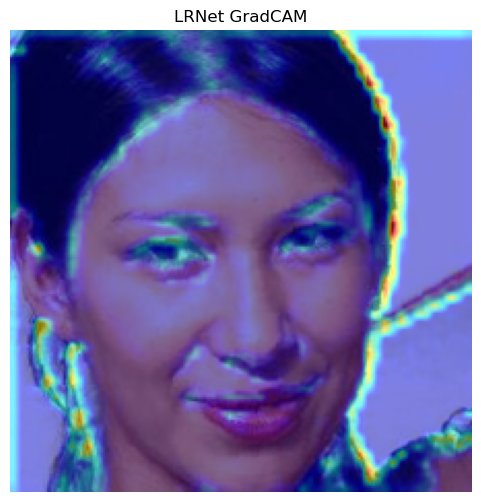

In [57]:
class LRNet(nn.Module):
    def __init__(self):
        super(LRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Load LRNet
model = LRNet()
model.load_state_dict(torch.load("../models/lrnet_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

# GradCAM for LRNet
raw_image = Image.open(test_image_path).convert('RGB').resize((224, 224))
image_np = np.array(raw_image).astype(np.float32) / 255.0
input_tensor = transform(raw_image).unsqueeze(0).to(device)

target_layer = model.layer2[0]

cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
visualization_lrnet = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(visualization_lrnet)
plt.axis('off')
plt.title("LRNet GradCAM")
plt.show()

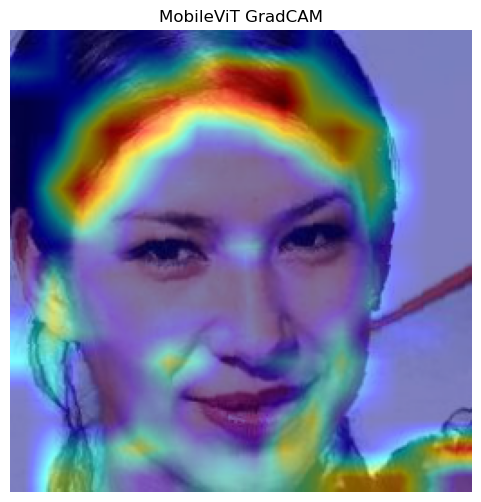

In [59]:
import timm

# Load MobileViT model
model = timm.create_model('mobilevit_s', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("../models/mobilevit_s_deepfake.pth", map_location='cpu'))
model = model.to(device)
model.eval()

# GradCAM for MobileViT
raw_image = Image.open(test_image_path).convert('RGB').resize((256, 256))
image_np = np.array(raw_image).astype(np.float32) / 255.0
input_tensor = transform_mobilevit(raw_image).unsqueeze(0).to(device)

target_layer = list(model.stages[3])[-1]

cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
visualization_mobilevit = show_cam_on_image(image_np, grayscale_cam[0], use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(visualization_mobilevit)
plt.axis('off')
plt.title("MobileViT GradCAM")
plt.show()